<a href="https://colab.research.google.com/github/deepanshu2207/Tutorials/blob/master/Structured_Output_With_Loop_haystack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Generating Structured Output with Loop-Based Auto-Correction

- **Level**: Intermediate
- **Time to complete**: 15 minutes
- **Prerequisites**: You must have an API key from an active OpenAI account as this tutorial is using the gpt-3.5-turbo model by OpenAI.
- **Components Used**: `PromptBuilder`, `OpenAIGenerator`, `OutputValidator` (Custom component)
- **Goal**: After completing this tutorial, you will have built a system that extracts unstructured data, puts it in a JSON schema, and automatically corrects errors in the JSON output from a large language model (LLM) to make sure it follows the specified structure.

> This tutorial uses Haystack 2.0 Beta. To learn more, read the [Haystack 2.0 Beta announcement](https://haystack.deepset.ai/blog/introducing-haystack-2-beta-and-advent) or see [Haystack 2.0 Beta Documentation](https://docs.haystack.deepset.ai/v2.0/docs).

## Overview
This tutorial demonstrates how to use Haystack 2.0-Beta's advanced [looping pipelines](https://docs.haystack.deepset.ai/v2.0/docs/pipelines#loops) with LLMs for more dynamic and flexible data processing. You'll learn how to extract structured data from unstructured data using an LLM, and to validate the generated output against a predefined schema.

This tutorial uses `gpt-3.5-turbo` to change unstructured passages into JSON outputs that follow the [Pydantic](https://github.com/pydantic/pydantic) schema. It uses a custom OutputValidator component to validate the JSON and loop back to make corrections, if necessary.

## Preparing the Colab Environment

Enable the debug mode of logging:

In [1]:
import logging

logging.basicConfig()
logging.getLogger("canals.pipeline.pipeline").setLevel(logging.DEBUG)

## Installing Dependencies
Install Haystack 2.0 Beta and [colorama](https://pypi.org/project/colorama/) with pip:

In [2]:
%%bash

pip install haystack-ai
pip install colorama
pip install google-ai-haystack

### Enabling Telemetry

Enable telemetry to let us know you're using this tutorial. (You can always opt out by commenting out this line). For details, see [Telemetry](https://docs.haystack.deepset.ai/docs/telemetry).

In [3]:
# from haystack.telemetry import tutorial_running

# tutorial_running(28)

## Defining a Schema to Parse the JSON Object

Define a simple JSON schema for the data you want to extract from a text passsage using the LLM. As the first step, define two [Pydantic models](https://docs.pydantic.dev/1.10/usage/models/), `City` and `CitiesData`, with suitable fields and types.

In [4]:
from typing import List, Dict, Union
from pydantic import BaseModel


class City(BaseModel):
    name: str
    country: str
    population: int


class CitiesData(BaseModel):
    cities: List[City]

> You can change these models according to the format you wish to extract from the text.

Then, generate a JSON schema from Pydantic models using `schema_json()`. You will later on use this schema in the prompt to instruct the LLM.

To learn more about the JSON schemas, visit [Pydantic Schema](https://docs.pydantic.dev/1.10/usage/schema/).  

In [5]:
json_schema = CitiesData.schema_json(indent=2)

## Creating a Custom Component: OutputValidator

`OutputValidator` is a custom component that validates if the JSON object the LLM generates complies with the provided [Pydantic model](https://docs.pydantic.dev/1.10/usage/models/). If it doesn't, OutputValidator returns an error message along with the incorrect JSON object to get it fixed in the next loop.

For more details about custom components, see [Creating Custom Components](https://docs.haystack.deepset.ai/v2.0/docs/custom-components).

In [6]:
import json
import random
import pydantic
from pydantic import ValidationError
from typing import Optional, List
from colorama import Fore
from haystack import component

# Define the component input parameters
@component
class OutputValidator:
    def __init__(self, pydantic_model: pydantic.BaseModel):
        self.pydantic_model = pydantic_model
        self.iteration_counter = 0

    # Define the component output
    @component.output_types(valid_replies=List[Union[str, Dict[str, str]]], invalid_replies=Optional[List[str]], error_message=Optional[str])
    def run(self, replies: List[Union[str, Dict[str, str]]]):

        self.iteration_counter += 1

        ## Try to parse the LLM's reply ##
        # If the LLM's reply is a valid object, return `"valid_replies"`
        try:
            print('Replies: ', replies)
            output_dict = json.loads(replies[0])
            self.pydantic_model.parse_obj(output_dict)
            print(
                Fore.GREEN
                + f"OutputValidator at Iteration {self.iteration_counter}: Valid JSON from LLM - No need for looping: {replies[0]}"
            )
            return {"valid_replies": replies}

        # If the LLM's reply is corrupted or not valid, return "invalid_replies" and the "error_message" for LLM to try again
        except (ValueError, ValidationError) as e:
            print(
                Fore.RED
                + f"OutputValidator at Iteration {self.iteration_counter}: Invalid JSON from LLM - Let's try again.\n"
                f"Output from LLM:\n {replies[0]} \n"
                f"Error from OutputValidator: {e}"
            )
            return {"invalid_replies": replies, "error_message": str(e)}

Then, create an OutputValidator instance with `CitiesData` that you have created before.

In [7]:
output_validator = OutputValidator(pydantic_model=CitiesData)

## Creating the Prompt

Write instructions for the LLM for converting a passage into a JSON format. Ensure the instructions explain how to identify and correct errors if the JSON doesn't match the required schema. Once you create the prompt, initialize PromptBuilder to use it.  

For information about Jinja2 template and PromptBuilder, see [PromptBuilder](https://docs.haystack.deepset.ai/v2.0/docs/promptbuilder).

In [8]:
from haystack.components.builders import PromptBuilder

prompt_template = """
Create a JSON object from the information present in this passage: {{passage}}.
Only use information that is present in the passage. Follow this JSON schema, but only return the actual instances without any additional schema definition:
{{schema}}
Make sure your response is a dict and not a list.
{% if invalid_replies and error_message %}
  You already created the following output in a previous attempt: {{invalid_replies}}
  However, this doesn't comply with the format requirements from above and triggered this Python exception: {{error_message}}
  Correct the output and try again. Just return the corrected output without any extra explanations.
{% endif %}
"""
prompt_builder = PromptBuilder(template=prompt_template)

## Initalizing the Generator

[OpenAIGenerator](https://docs.haystack.deepset.ai/v2.0/docs/openaigenerator) generates
text using OpenAI's `gpt-3.5-turbo` model by default. Set the `OPENAI_API_KEY` variable and provide a model name to the Generator.

In [9]:
import os
from getpass import getpass
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator


# from haystack.components.generators.google_ai import GoogleAIGeminiGenerator
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('gemini_key')
generator = GoogleAIGeminiGenerator(model="gemini-pro")

## Building the Pipeline

Add all components to your pipeline and connect them. Add connections from `output_validator` back to the `prompt_builder` for cases where the produced JSON doesn't comply with the JSON schema. Set `max_loops_allowed` to avoid infinite looping.

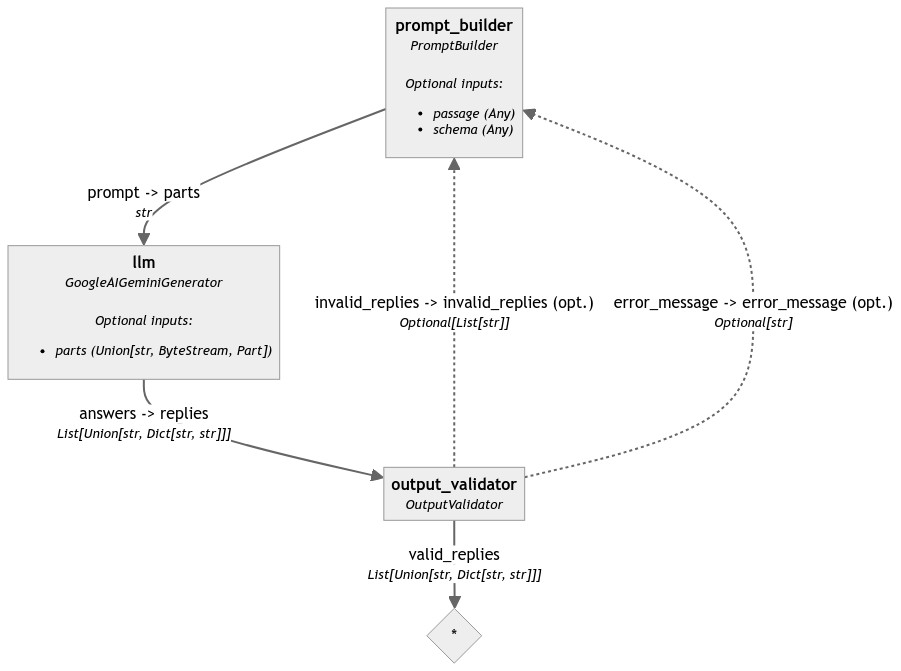

In [10]:
from haystack import Pipeline

pipeline = Pipeline(max_loops_allowed=5)

# Add components to your pipeline
pipeline.add_component(instance=prompt_builder, name="prompt_builder")
pipeline.add_component(instance=generator, name="llm")
pipeline.add_component(instance=output_validator, name="output_validator")

# Now, connect the components to each other
pipeline.connect("prompt_builder", "llm")
pipeline.connect("llm", "output_validator")
# If a component has more than one output or input, explicitly specify the connections:
pipeline.connect("output_validator.invalid_replies", "prompt_builder.invalid_replies")
pipeline.connect("output_validator.error_message", "prompt_builder.error_message")

### Visualize the Pipeline

Draw the pipeline with the [`draw()`](https://docs.haystack.deepset.ai/v2.0/docs/drawing-pipeline-graphs) method to confirm the connections are correct. You can find the diagram in the Files section of this Colab.

In [11]:
pipeline.draw("auto-correct-pipeline.png")

## Testing the Pipeline

Run the pipeline with an example passage that you want to convert into a JSON format and the `json_schema` you have created for `CitiesData`. For the given example passage, the generated JSON object should be like:
```json
{
  "cities": [
    {
      "name": "Berlin",
      "country": "Germany",
      "population": 3850809
    },
    {
      "name": "Paris",
      "country": "France",
      "population": 2161000
    },
    {
      "name": "Lisbon",
      "country": "Portugal",
      "population": 504718
    }
  ]
}
```
The output of the LLM should be compliant with the `json_schema`. If the LLM doesn't generate the correct JSON object, it will loop back and try again.

In [12]:
passage = "Berlin is the capital of Germany. It has a population of 3,850,809. Paris, France's capital, has 2.161 million residents. Lisbon is the capital and the largest city of Portugal with the population of 504,718."
result = pipeline.run({"prompt_builder": {"passage": passage, "schema": json_schema}})

Replies:  ['```\n{\n  "cities": [\n    {\n      "name": "Berlin",\n      "country": "Germany",\n      "population": 3850809\n    },\n    {\n      "name": "Paris",\n      "country": "France",\n      "population": 2161000\n    },\n    {\n      "name": "Lisbon",\n      "country": "Portugal",\n      "population": 504718\n    }\n  ]\n}\n```']
OutputValidator at Iteration 1: Invalid JSON from LLM - Let's try again.
Output from LLM:
 ```
{
  "cities": [
    {
      "name": "Berlin",
      "country": "Germany",
      "population": 3850809
    },
    {
      "name": "Paris",
      "country": "France",
      "population": 2161000
    },
    {
      "name": "Lisbon",
      "country": "Portugal",
      "population": 504718
    }
  ]
}
``` 
Error from OutputValidator: Expecting value: line 1 column 1 (char 0)
Replies:  ['{\n  "cities": [\n    {\n      "name": "Berlin",\n      "country": "Germany",\n      "population": 3850809\n    },\n    {\n      "name": "Paris",\n      "country": "France",\n     

> If you encounter `PipelineMaxLoops: Maximum loops count (5) exceeded for component 'prompt_builder'.` error, consider increasing the maximum loop count or simply rerun the pipeline.

### Print the Correct JSON
If you didn't get any error, you can now print the corrected JSON.

In [14]:
valid_reply = result["output_validator"]["valid_replies"][0]
valid_json = json.loads(valid_reply)
print(valid_json)

{'cities': [{'name': 'Berlin', 'country': 'Germany', 'population': 3850809}, {'name': 'Paris', 'country': 'France', 'population': 2161000}, {'name': 'Lisbon', 'country': 'Portugal', 'population': 504718}]}


🎉 Congratulations! You've built a system that generates structured JSON out of unstructured text passages, and auto-corrects it by using the looping functionality of Haystack pipelines.